In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


from math import nan

from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
#from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
import keras.losses as kl
from tensorflow.keras.callbacks import EarlyStopping

from core.classes import FeatureEngineer, DataImputation

pd.set_option('display.max_columns', None)

In [2]:
path = '../data/processed/combined_data_with_elasticity.csv'
df = pd.read_csv(path, index_col='date', skipfooter=1)


C:\Users\judit\AppData\Local\Temp\ipykernel_42408\3254533201.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(path, index_col='date', skipfooter=1)


In [3]:
class Model(TransformerMixin, BaseEstimator):
    """Imputs missing values. """
    
    def __init__(self,columns, model_start, model_middle, model_end): 
        """Initalizes the attributes."""
        self.features = []
        self.num_cols = []
        self.dict_num = {}
        self.model_start = model_start
        self.model_middle = model_middle 
        self.model_end = model_end
        self.columns = columns
        self.weight_mond = 0
        self.weight_fer = 0
        self.weight_mond_fer = 0
        self.weight_fer_fer = 0
        self.weight_lindt = 0

    def fit(self, X, y=None):
        mask_f = X.loc[:,'Ferrero'].isna()
        mask_l = X.loc[:,'LindtSpruengli'].isna()
        number_mond = (~X['Mondelez'].isna()).sum()
        number_fer = (~X['Ferrero'].isna()).sum()
        number_lindt = (~X['LindtSpruengli'].isna()).sum()
        number_all = number_mond + number_fer + number_lindt
        self.weight_mond_fer = number_mond / (number_mond + number_fer)
        self.weight_fer_fer = number_fer / (number_mond + number_fer)
        self.weight_mond = number_mond / number_all
        self.weight_fer = number_fer / number_all
        self.weight_lindt = number_lindt / number_all
        feat_start = X#.loc[:, self.columns + ['Mondelez.1']]
        target_start = y
        self.model_start.fit(feat_start.loc[:, self.columns + ['Mondelez']], target_start)

        feat_middle = X.copy()
        feat_middle = feat_middle.loc[~mask_f , :]
        target_middle = y.loc[~mask_f]
        feat_middle['target_pred_by_1'] = self.model_start.predict(feat_middle.loc[:, self.columns + ['Mondelez']])

        self.model_middle.fit( feat_middle.loc[:,['target_pred_by_1', 'Ferrero']],target_middle)

        feat_end = X.copy()
        feat_end = feat_end.loc[~mask_f & ~mask_l, :]
        target_end = y.loc[~mask_f & ~mask_l]
        feat_end['target_pred_by_1'] = self.model_start.predict(feat_end.loc[:, self.columns + ['Mondelez']])
        feat_end['target_pred_by_2'] = self.model_middle.predict(feat_end.loc[:,['target_pred_by_1', 'Ferrero']])

        self.model_end.fit(feat_end.loc[:,['target_pred_by_2', 'LindtSpruengli']],target_end)

        return self
    
    def transform(self, X, y=None):
        """Fill the missing values and drop some columns.
        
        
        """
        df = X.copy()

        self.features = df.columns.values
        return df
    
    def predict(self, X, y=None):
        """Fill the missing values and drop some columns.
        
        
        """
        mask_f = X.loc[:,'Ferrero'].isna()
        mask_l = X.loc[:,'LindtSpruengli'].isna()

        #feat_start = X#.loc[:, self.columns + ['Mondelez.1']]
        #target_start = y
        #model_start.fit(feat_start.loc[:, self.columns + ['Mondelez.1']], target_start)
        result = pd.DataFrame.from_dict({'index': X.index.values})
        result = result.set_index('index')
        result['pred_m']=nan
        result['pred_mf']=nan
        result['pred_mfl']=nan
        feat_middle = X.copy()
        feat_middle = feat_middle.loc[~mask_f , :]
        target_middle = y.loc[~mask_f]
        feat_middle['target_pred_by_1'] = self.model_start.predict(feat_middle.loc[:, self.columns + ['Mondelez']])
        result.loc[: ,'pred_m']= self.model_start.predict(X.loc[:, self.columns + ['Mondelez']])
       
        feat_end = X.copy()
        feat_end = feat_end.loc[~mask_f & ~mask_l, :]
        target_end = y.loc[~mask_f & ~mask_l]
        feat_end['target_pred_by_1'] = self.model_start.predict(feat_end.loc[:, self.columns + ['Mondelez']])
        feat_end['target_pred_by_2'] = self.model_middle.predict(feat_end.loc[:,['target_pred_by_1', 'Ferrero']])
        result.loc[~mask_f ,'pred_mf']= self.model_middle.predict(feat_middle.loc[:, ['target_pred_by_1', 'Ferrero']])
        result.loc[~mask_f & ~mask_l ,'pred_mfl']= self.model_end.predict(feat_end.loc[:,  ['target_pred_by_2', 'LindtSpruengli']])
        result['final'] = 0
        result.loc[mask_f, 'final'] = result.loc[mask_f, 'pred_m'] 
        result.loc[~mask_f & mask_l, 'final'] = result.loc[~mask_f & mask_l, 'pred_m'] * self.weight_mond_fer + result.loc[~mask_f & mask_l, 'pred_mf'] * self.weight_fer_fer 
        result.loc[~mask_l, 'final'] = result.loc[~mask_l,'pred_m'] * self.weight_mond + result.loc[~mask_l,'pred_mf'] * self.weight_fer + result.loc[~mask_l,'pred_mfl'] * self.weight_lindt
        return result
    
    def get_feature_names_out(self, input_features=None):
        """Returns the names of the features."""
        return self.features

In [17]:
class Model_pred_error(TransformerMixin, BaseEstimator):
    """Imputs missing values. """
    
    def __init__(self,columns, model_start, model_middle, model_end): 
        """Initalizes the attributes."""
        self.features = []
        self.num_cols = []
        self.dict_num = {}
        self.model_start = model_start
        self.model_middle = model_middle 
        self.model_end = model_end
        self.columns = columns
        self.weight_mond = 0
        self.weight_fer = 0
        self.weight_mond_fer = 0
        self.weight_fer_fer = 0
        self.weight_lindt = 0
        self.eta = 0.9

    def fit(self, X, y=None):
        mask_f = X.loc[:,'Ferrero'].isna()
        mask_l = X.loc[:,'LindtSpruengli'].isna()
        number_mond = (~X['Mondelez'].isna()).sum()
        number_fer = (~X['Ferrero'].isna()).sum()
        number_lindt = (~X['LindtSpruengli'].isna()).sum()
        number_all = number_mond + number_fer + number_lindt
        self.weight_mond_fer = number_mond / (number_mond + number_fer)
        self.weight_fer_fer = number_fer / (number_mond + number_fer)
        self.weight_mond = number_mond / number_all
        self.weight_fer = number_fer / number_all
        self.weight_lindt = number_lindt / number_all
        feat_start = X#.loc[:, self.columns + ['Mondelez.1']]
        target_start = y
        self.model_start.fit(feat_start.loc[:, self.columns + ['Mondelez']], target_start)
        y_start_predicted = self.model_start.predict(feat_start.loc[:, self.columns + ['Mondelez']])
        
        feat_middle = X.copy()
        #feat_middle = feat_middle.loc[~mask_f , :]
        target_middle = (y-self.eta * y_start_predicted).loc[~mask_f]
        #feat_middle['target_pred_by_1'] = self.model_start.predict(feat_middle.loc[:, self.columns + ['Mondelez']])

        self.model_middle.fit( feat_middle.loc[~mask_f,self.columns + ['Mondelez', 'Ferrero']],target_middle)
        y_middle_predicted = self.model_middle.predict(feat_middle.loc[~mask_f & ~mask_l,self.columns + ['Mondelez', 'Ferrero']])
        feat_end = X.copy()
        feat_end = feat_end.loc[~mask_f & ~mask_l, :]
        target_end =( y-self.eta * y_start_predicted).loc[~mask_f & ~mask_l] 
        target_end = target_end - self.eta**2 * y_middle_predicted
        #feat_end['target_pred_by_1'] = self.model_start.predict(feat_end.loc[:, self.columns + ['Mondelez']])
        #feat_end['target_pred_by_2'] = self.model_middle.predict(feat_end.loc[:,['target_pred_by_1', 'Ferrero']])

        self.model_end.fit(feat_end.loc[:, self.columns + ['Mondelez', 'Ferrero','LindtSpruengli']],target_end)

        return self
    
    def transform(self, X, y=None):
        """Fill the missing values and drop some columns.
        
        
        """
        df = X.copy()

        self.features = df.columns.values
        return df
    
    def predict(self, X, y=None):
        """Fill the missing values and drop some columns.
        
        
        """
        mask_f = X.loc[:,'Ferrero'].isna()
        mask_l = X.loc[:,'LindtSpruengli'].isna()

        #feat_start = X#.loc[:, self.columns + ['Mondelez.1']]
        #target_start = y
        #model_start.fit(feat_start.loc[:, self.columns + ['Mondelez.1']], target_start)
        result = pd.DataFrame.from_dict({'index': X.index.values})
        result = result.set_index('index')
        result['pred_m']=nan
        result['pred_mf']=nan
        result['pred_mfl']=nan
        feat_middle = X.copy()
        #feat_middle = feat_middle.loc[~mask_f , :]
        #target_middle = y.loc[~mask_f]
        result['pred_m'] = self.model_start.predict(feat_middle.loc[:, self.columns + ['Mondelez']])
        #result.loc[: ,'pred_m']= self.model_start.predict(X.loc[:, self.columns + ['Mondelez']])
       
        #feat_end = X.copy()
        #feat_end = feat_end.loc[~mask_f & ~mask_l, :]
        #target_end = y.loc[~mask_f & ~mask_l]
        #feat_end['target_pred_by_1'] = self.model_start.predict(feat_end.loc[:, self.columns + ['Mondelez']])
        #feat_end['target_pred_by_2'] = self.model_middle.predict(feat_end.loc[:,['target_pred_by_1', 'Ferrero']])
        
        result.loc[~mask_f ,'pred_mf']= self.model_middle.predict(feat_middle.loc[~mask_f, self.columns + ['Mondelez', 'Ferrero']])
        result.loc[~mask_f & ~mask_l ,'pred_mfl']= self.model_end.predict(feat_middle.loc[~mask_f & ~mask_l,  self.columns + ['Mondelez', 'Ferrero', 'LindtSpruengli']])
        result['final'] = 0
        result.loc[mask_f, 'final'] = result.loc[mask_f, 'pred_m'] 
        result.loc[~mask_f & mask_l, 'final'] = result.loc[~mask_f & mask_l, 'pred_m'] * self.eta + result.loc[~mask_f & mask_l, 'pred_mf'] 
        result.loc[~mask_l, 'final'] = result.loc[~mask_l,'pred_m'] * self.eta + result.loc[~mask_l,'pred_mf'] * self.eta**2 + result.loc[~mask_l,'pred_mfl']
        return result
    
    def get_feature_names_out(self, input_features=None):
        """Returns the names of the features."""
        return self.features

In [4]:
def preprocessing(df, dict_lag,number_train, target_name):
    shares = ['Ferrero', 'LindtSpruengli', 'Mondelez']
    columns = [x for x in list(dict_lag) if x not in shares]
    df_selected_col = df.loc[:, shares + columns + [target_name]]
    df_selected_col = df_selected_col.dropna(subset = target_name)
    df_train = df_selected_col.iloc[:number_train, :]
    df_test = df_selected_col.iloc[number_train: , :]
    target_train = df_train[target_name]
    target_test = df_test[target_name]
    features_train = df_train.loc[:, shares + columns]
    features_test = df_test.loc[:, shares + columns]
    pipeline = Pipeline([('DaIm', DataImputation(shares)), 
                     ('FE', FeatureEngineer(dict_lag)),
                     ('sca', StandardScaler())])
    
    features_train_transf = pipeline.fit_transform(features_train)
    features_test_transf = pipeline.transform(features_test)
    # make the features into a dataframe again
    features_train_transf = pd.DataFrame(columns=pipeline.get_feature_names_out(), data=features_train_transf)
    features_train_transf.index=features_train.index
    features_test_transf = pd.DataFrame(columns=pipeline.get_feature_names_out(), data=features_test_transf)
    features_test_transf.index=features_test.index
    columns = [x for x in pipeline.get_feature_names_out() if x not in shares]
    return features_train_transf, features_test_transf, target_train, target_test, columns

In [10]:
def train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train, target_name, model_simple =0):
    # Train Test split
    features_train_transf, features_test_transf, target_train, target_test, columns = preprocessing(df, dict_lag,number_train, target_name)

    # Model
    #columns = [x for x in pipeline.get_feature_names_out() if x not in shares]
    if model_simple == 0:
        mod = Model( columns,
             model_start, model_middle, 
             model_end)
    else: 
       mod = Model_pred_error( columns,
             model_start, model_middle, 
             model_end) 
    mod.fit(features_train_transf , target_train)

    #Predict Train data
    results = mod.predict(features_train_transf, target_train)
    print('MSE on Train set: ', mean_squared_error(results['final'], target_train))
    results['target']=target_train
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
    ax.plot(results.index,results.pred_m.values, label = 'm', color = 'blue');
    ax.plot(results.index,results.pred_mf.values, label = 'mf', color = 'lightblue');
    ax.plot(results.index,results.pred_mfl.values, label = 'mfl', color = 'green');
    ax.plot(results.index,results.final.values, label = 'final', color = 'purple');
    ax.plot(results.index, target_train,  label = 'target', color = 'orange');
    plt.xticks(rotation=90)
    ax.legend()
    # Predict testdata 
    results_test = mod.predict(features_test_transf, target_test)
    results_test['target']=target_test
    print('MSE on Test set: ', mean_squared_error(results_test['final'], target_test))
    fig_test, ax_test = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
    ax_test.plot(results_test.index,results_test.pred_m.values, label = 'm', color = 'blue');
    ax_test.plot(results_test.index,results_test.pred_mf.values, label = 'mf', color = 'lightblue');
    ax_test.plot(results_test.index,results_test.pred_mfl.values, label = 'mfl', color = 'green');
    ax_test.plot(results_test.index,results_test.final.values, label = 'final', color = 'purple');
    ax_test.plot(results_test.index,target_test, label = 'target', color = 'orange');
    plt.xticks(rotation=90)
    ax_test.legend()
    return results, results_test
    

In [6]:
columns = [#'Beschäftigte_WZ08-1082',
 #'Geleistete Arbeitsstunden_WZ08-1082',
 #'Bruttolohn- und -gehaltssumme_WZ08-1082',
 #'Umsatz_WZ08-1082',
 'ErzPr_Schokolade u.a. kakaoh. Leb.m.zuber.,in Verp.<=2kg',
 'EinfPr_Süßwaren (ohne Dauerbackwaren)',
 'VPI_Schokoladen',
 'PCOCOUSDM',
 'PCOFFROBUSDM']
target_name = 'elasticity_cacao'
number_train = 74
shares = ['Ferrero', 'LindtSpruengli', 'Mondelez']
dict_lag = {}
for k in shares:
    dict_lag.update({k: [0]})
for k in [#'Beschäftigte_WZ08-1082',
 #'Umsatz_WZ08-1082',
 'EinfPr_Süßwaren (ohne Dauerbackwaren)',
 'VPI_Schokoladen',
 'PCOCOUSDM',
 'PCOFFROBUSDM']:
    dict_lag.update({k: [1]})

for k in ['Geleistete Arbeitsstunden_WZ08-1082',
 'Bruttolohn- und -gehaltssumme_WZ08-1082','ErzPr_Schokolade u.a. kakaoh. Leb.m.zuber.,in Verp.<=2kg']:
    dict_lag.update({k: [0]})


<Axes: >

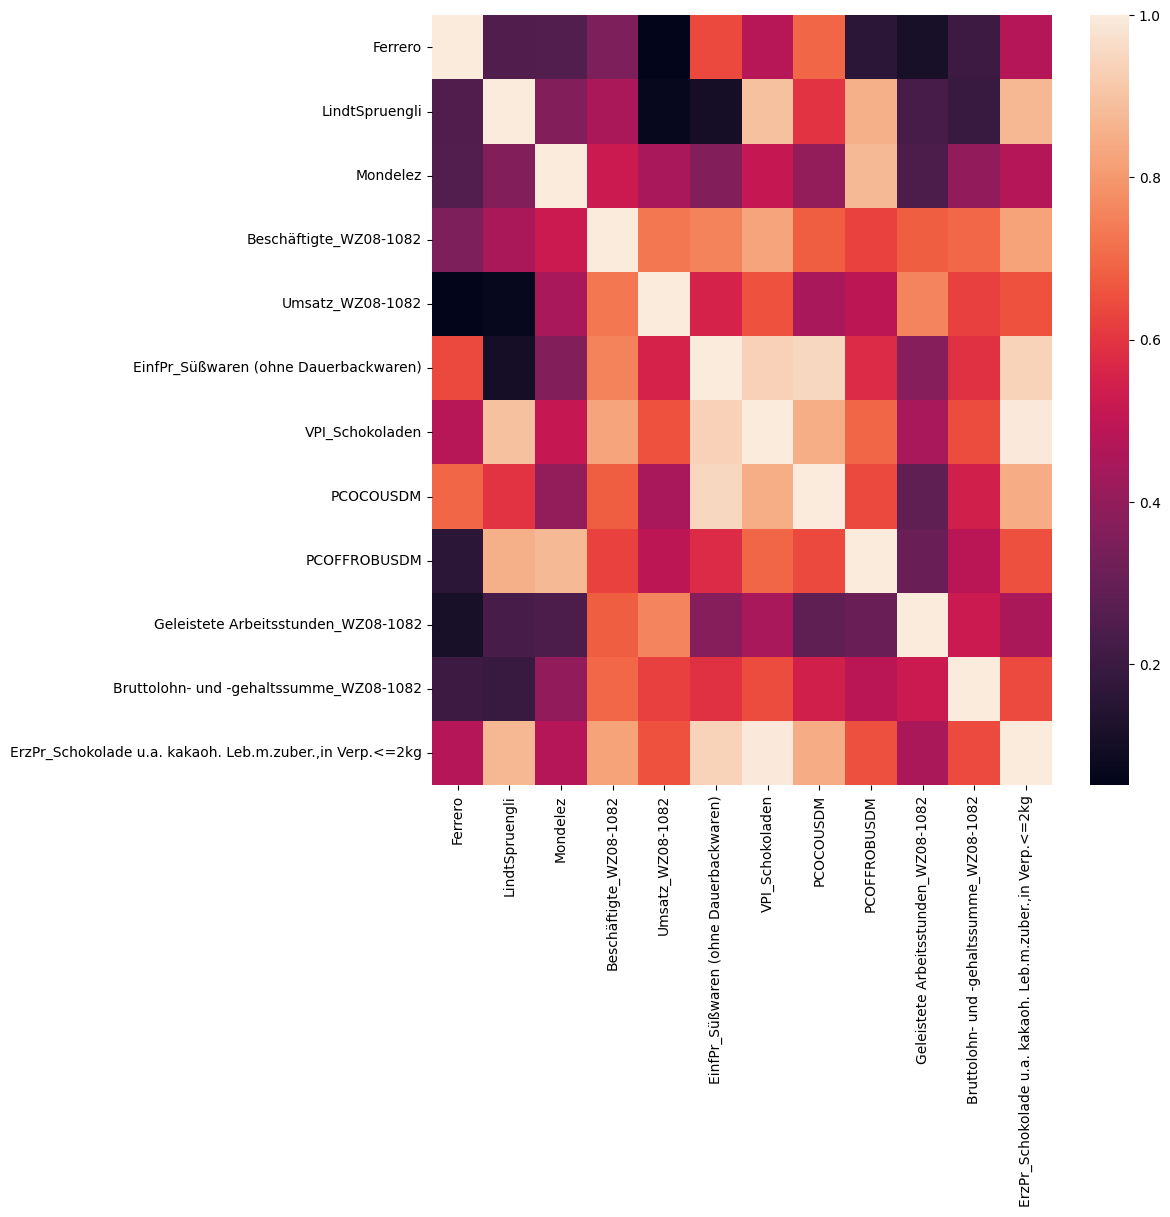

In [51]:
corr = df.loc[:,list(dict_lag)].corr()
fig_heatmap, ax_heatmap = plt.subplots(nrows=1, ncols=1, figsize=(10,10));
sns.heatmap(corr.abs(), xticklabels=True, yticklabels=True, ax=ax_heatmap)

## Linear Regression

C:\Users\judit\AppData\Local\Temp\ipykernel_42408\2570047379.py:92: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 1.30964688  0.44641301 -0.20000447 -2.13494735 -0.56737769 -1.84940073
  0.92360166  0.9696505   2.58910847  2.9207211   0.48768911 -2.51738545
  3.16811144  2.0114151  -1.02662773 -3.25555438 -3.5346996  -2.38553709
 -0.2972176   0.69623384  1.41567192  1.53332402 -1.84375139 -3.88668406
 -1.54724296 -3.77442549 -2.80581278]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result.loc[mask_f, 'final'] = result.loc[mask_f, 'pred_m']
C:\Users\judit\AppData\Local\Temp\ipykernel_42408\2570047379.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  0.55979504  -1.09069352  -1.27907944  -7.68012444  -5.27226443
  -6.47385258  -7.30473416  -9.17031078 -13.25010839]' has dt

MSE on Train set:  51.59261647270719
MSE on Test set:  188.28681937441223


(               pred_m   pred_mf  pred_mfl      final     target
 index                                                          
 2019-01-31   1.309647       NaN       NaN   1.309647   0.207187
 2019-02-28   0.446413       NaN       NaN   0.446413   2.208051
 2019-03-31  -0.200004       NaN       NaN  -0.200004  -0.367747
 2019-04-30  -2.134947       NaN       NaN  -2.134947  -1.450762
 2019-05-31  -0.567378       NaN       NaN  -0.567378  -0.543008
 ...               ...       ...       ...        ...        ...
 2024-10-31  11.289995  9.983874       NaN  10.782658   1.749173
 2024-11-30   3.884205  2.779279  7.361336   3.580021   0.306333
 2024-12-31   1.578167  0.382516  6.531952   1.287124  20.434410
 2025-01-31  -1.650637 -3.132830  6.561984  -1.945138   1.778236
 2025-02-28   2.224429  0.337627  3.626999   1.559874   1.563292
 
 [74 rows x 5 columns],
                pred_m    pred_mf  pred_mfl      final     target
 index                                                         

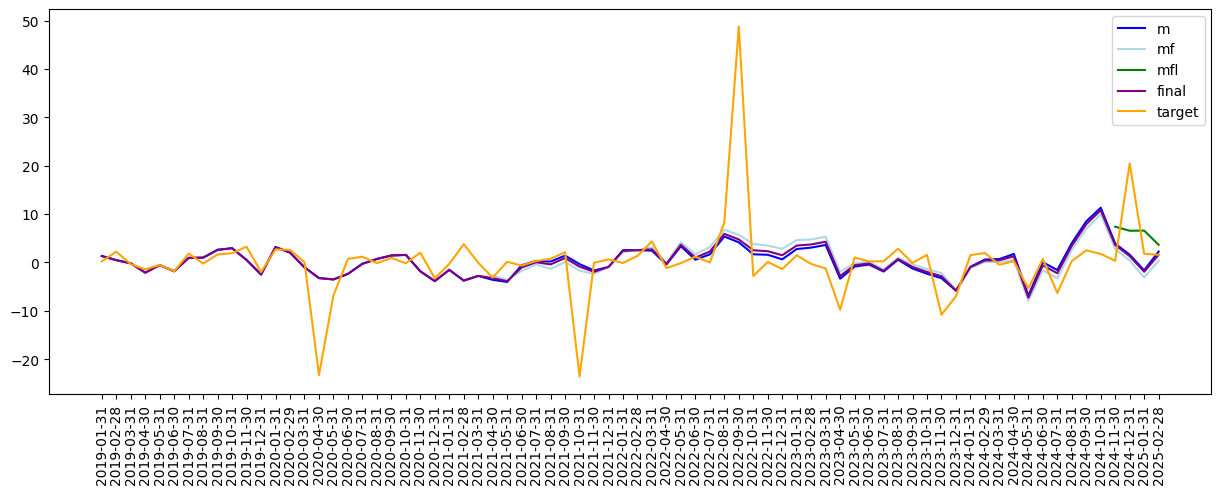

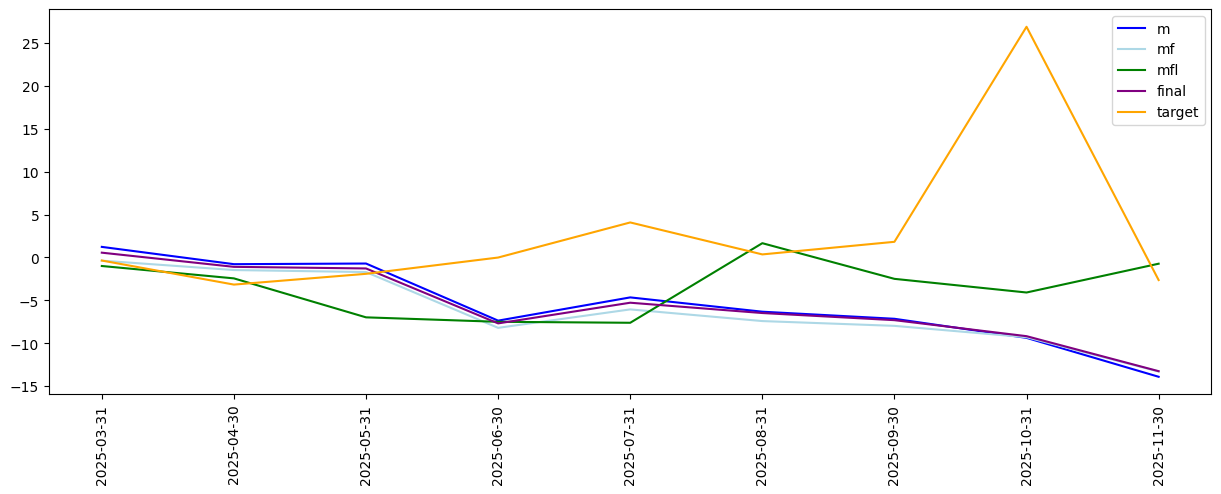

In [11]:
model_start = LinearRegression()
model_middle = LinearRegression()
model_end = LinearRegression()
train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train, target_name)

MSE on Train set:  45.59771336162016
MSE on Test set:  1491.9218742681599


C:\Users\judit\AppData\Local\Temp\ipykernel_42408\2041393093.py:96: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 1.30964688  0.44641301 -0.20000447 -2.13494735 -0.56737769 -1.84940073
  0.92360166  0.9696505   2.58910847  2.9207211   0.48768911 -2.51738545
  3.16811144  2.0114151  -1.02662773 -3.25555438 -3.5346996  -2.38553709
 -0.2972176   0.69623384  1.41567192  1.53332402 -1.84375139 -3.88668406
 -1.54724296 -3.77442549 -2.80581278]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result.loc[mask_f, 'final'] = result.loc[mask_f, 'pred_m']
C:\Users\judit\AppData\Local\Temp\ipykernel_42408\2041393093.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ -8.1120202   -8.18997919 -27.77094086 -39.99807832 -43.6010066
 -18.32011128 -34.40605938 -40.01015146 -54.23913264]' has dty

(               pred_m   pred_mf   pred_mfl      final     target
 index                                                           
 2019-01-31   1.309647       NaN        NaN   1.309647   0.207187
 2019-02-28   0.446413       NaN        NaN   0.446413   2.208051
 2019-03-31  -0.200004       NaN        NaN  -0.200004  -0.367747
 2019-04-30  -2.134947       NaN        NaN  -2.134947  -1.450762
 2019-05-31  -0.567378       NaN        NaN  -0.567378  -0.543008
 ...               ...       ...        ...        ...        ...
 2024-10-31  11.289995  1.247631        NaN  11.408627   1.749173
 2024-11-30   3.884205 -2.112027  -1.478709   0.306333   0.306333
 2024-12-31   1.578167  2.394923  17.074172  20.434410  20.434410
 2025-01-31  -1.650637  1.534244   2.021071   1.778236   1.778236
 2025-02-28   2.224429 -0.140405  -0.324966   1.563292   1.563292
 
 [74 rows x 5 columns],
                pred_m   pred_mf   pred_mfl      final     target
 index                                            

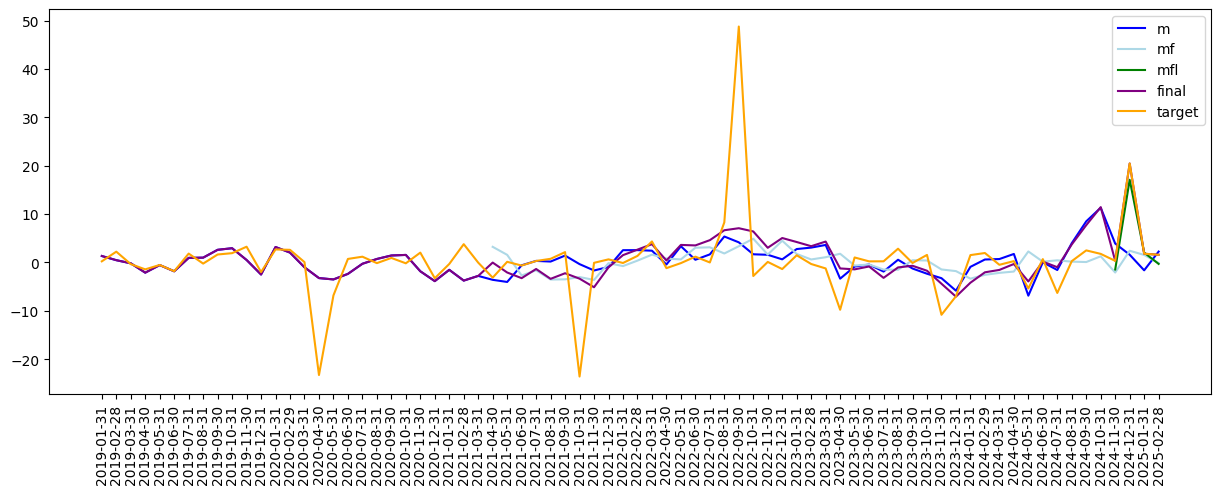

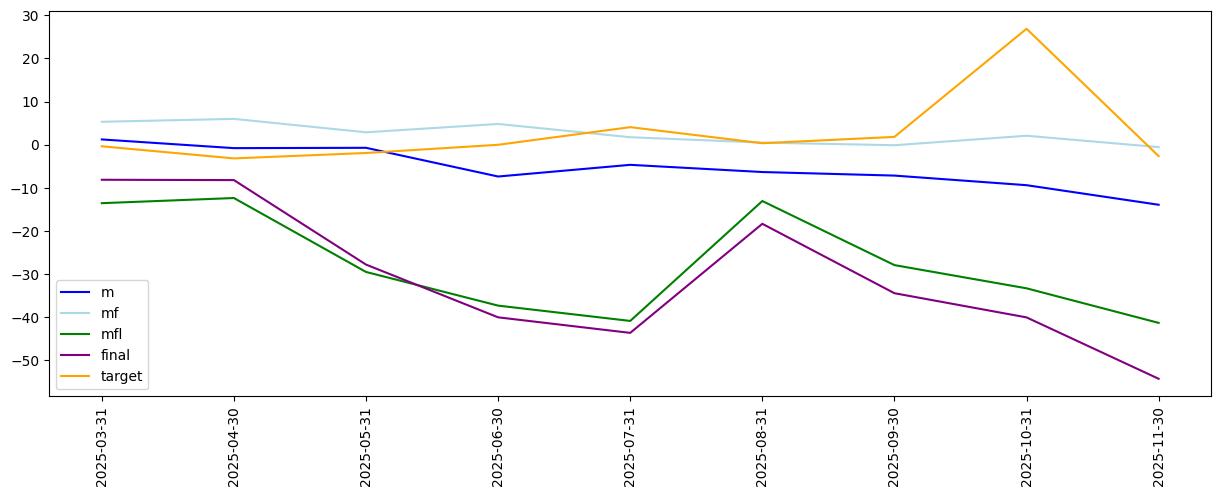

In [18]:
model_start = LinearRegression()
model_middle = LinearRegression()
model_end = LinearRegression()
train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train, target_name, model_simple=1)

## LinearSVR

MSE on Train set:  57.637634165948164
MSE on Test set:  80.73711408619852


C:\Users\judit\AppData\Local\Temp\ipykernel_42408\2570047379.py:92: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.63630496 -0.22624933 -0.48299778 -1.39629751 -0.44885905 -1.23577749
  1.15305466  1.30846261  1.72559827  1.89196306  0.09384829 -1.67904313
  1.71359895  0.99822447  0.08700914 -2.14822446 -2.92345579 -1.73293825
  0.04690974 -0.16538421  1.20462083  1.23201192 -0.69622369 -2.0735235
 -0.44786477 -1.09871332 -0.09080392]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result.loc[mask_f, 'final'] = result.loc[mask_f, 'pred_m']
C:\Users\judit\AppData\Local\Temp\ipykernel_42408\2570047379.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 1.11071708 -0.08912093 -0.12620499 -0.53947849  1.40591296 -0.2172583
  0.66553633  0.37395584 -2.53563034]' has dtype incompa

,pred_m,pred_mf,pred_mfl,final,target
index,,,,,
2019-01-31,0.636305,NaN,NaN,0.636305,0.207187
2019-02-28,-0.226249,NaN,NaN,-0.226249,2.208051
2019-03-31,-0.482998,NaN,NaN,-0.482998,-0.367747
2019-04-30,-1.396298,NaN,NaN,-1.396298,-1.450762
2019-05-31,-0.448859,NaN,NaN,-0.448859,-0.543008
...,...,...,...,...,...
2024-10-31,1.898587,1.758277,NaN,1.844086,1.749173
2024-11-30,-0.367156,-0.184989,0.306333,-0.277109,0.306333
2024-12-31,-2.095383,-1.660531,0.960040,-1.834105,20.434410


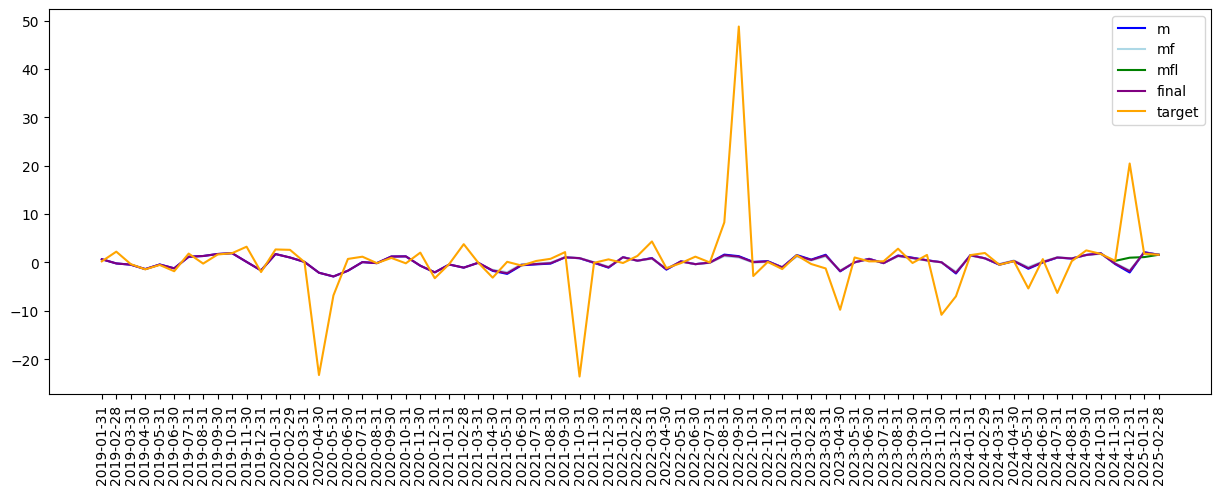

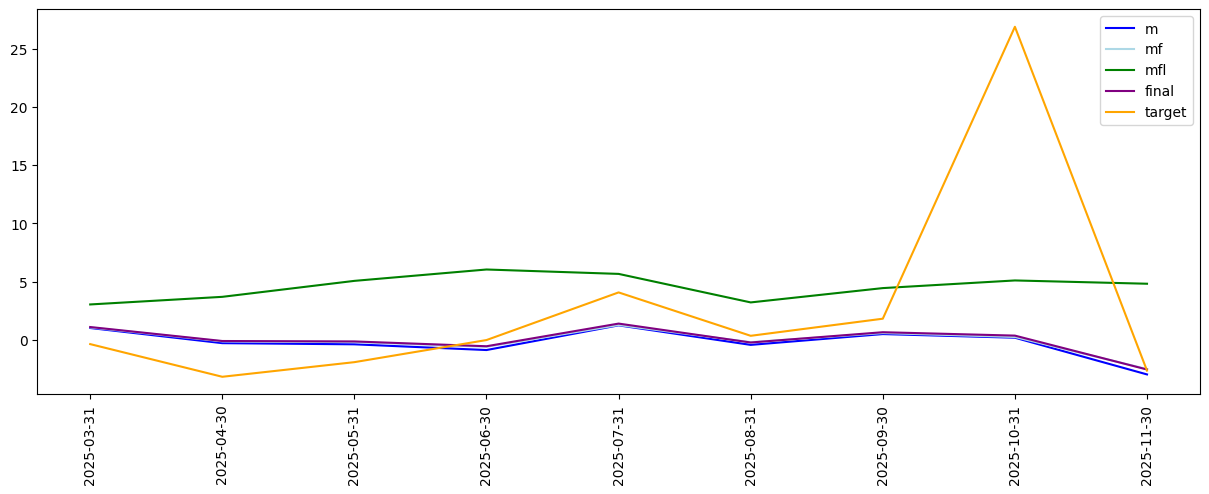

In [19]:
model_start = LinearSVR()
model_middle = LinearSVR()
model_end = LinearSVR()
results, results_test = train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train, target_name)
results

MSE on Train set:  54.760244984299916
MSE on Test set:  149.04874804832593


C:\Users\judit\AppData\Local\Temp\ipykernel_42408\2041393093.py:96: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.62755345 -0.23488685 -0.49171659 -1.40698124 -0.45360962 -1.24133466
  1.15642774  1.31189494  1.73021764  1.89674768  0.09250941 -1.68308014
  1.71998288  1.00688275  0.0852497  -2.15718675 -2.93714312 -1.74240644
  0.04143291 -0.17020269  1.20627906  1.23434596 -0.7025225  -2.08328907
 -0.4549434  -1.10931332 -0.09806699]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result.loc[mask_f, 'final'] = result.loc[mask_f, 'pred_m']
C:\Users\judit\AppData\Local\Temp\ipykernel_42408\2041393093.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.23354414 -1.04307403 -3.86247136 -5.68869633 -5.65528201 -1.65719286
 -4.33667892 -6.45611538 -9.87236915]' has dtype incom

,pred_m,pred_mf,pred_mfl,final,target
index,,,,,
2019-01-31,0.627553,NaN,NaN,0.627553,0.207187
2019-02-28,-0.234887,NaN,NaN,-0.234887,2.208051
2019-03-31,-0.491717,NaN,NaN,-0.491717,-0.367747
2019-04-30,-1.406981,NaN,NaN,-1.406981,-1.450762
2019-05-31,-0.453610,NaN,NaN,-0.453610,-0.543008
...,...,...,...,...,...
2024-10-31,1.886945,1.058177,NaN,2.756428,1.749173
2024-11-30,-0.389751,0.454943,0.289719,0.307447,0.306333
2024-12-31,-2.114790,0.018149,5.245738,3.357127,20.434410


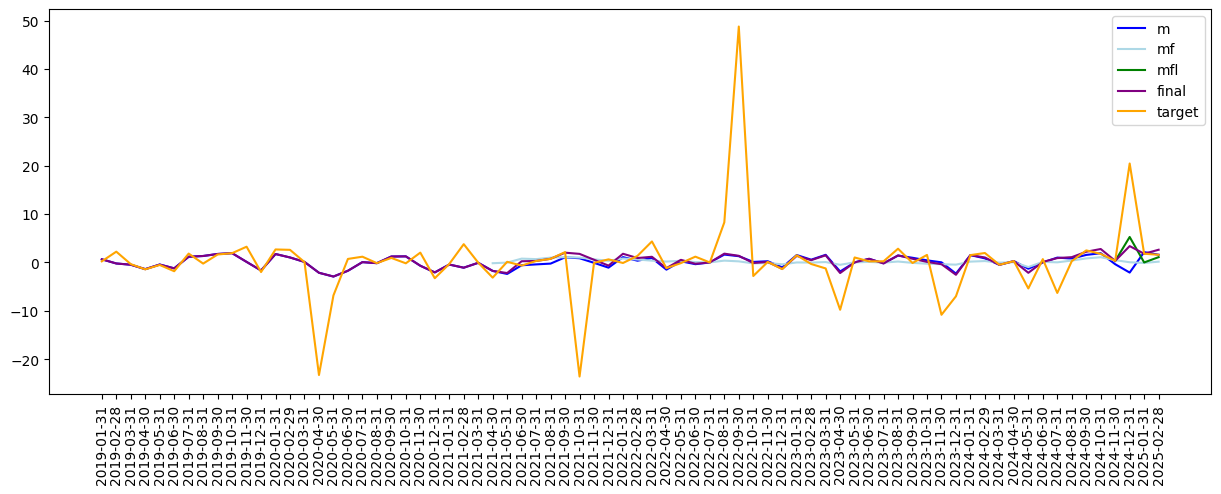

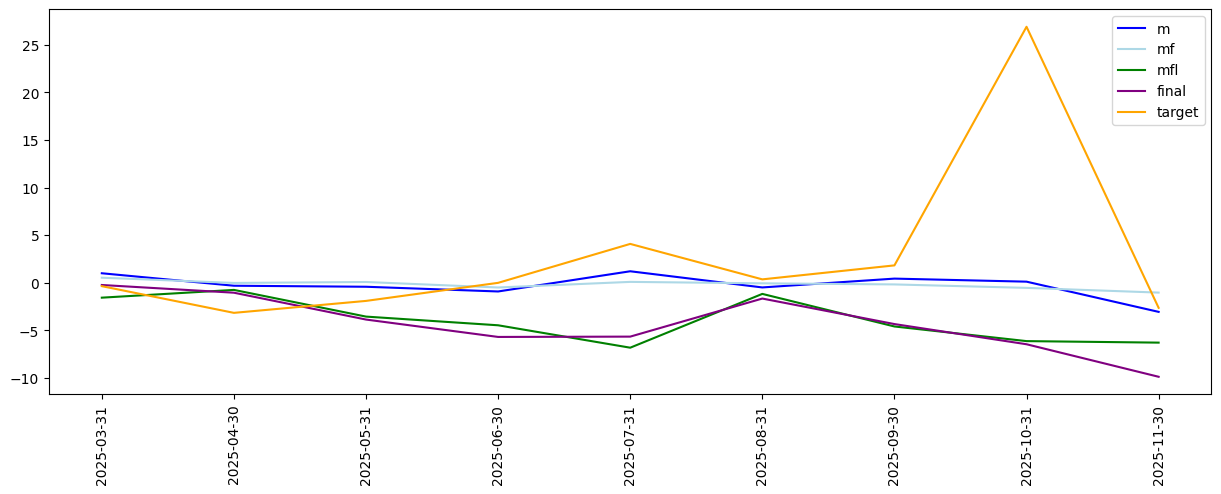

In [20]:
model_start = LinearSVR()
model_middle = LinearSVR()
model_end = LinearSVR()
results, results_test = train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train, target_name, model_simple=1)
results

MSE on Train set:  56.52560607812792
MSE on Test set:  81.16527847489822


C:\Users\judit\AppData\Local\Temp\ipykernel_42408\2570047379.py:92: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.62043696 -0.13953312 -0.36541505 -1.35061455 -0.03965223 -1.2837199
  1.13391988  1.2245284   1.52051117  1.67184631  1.42296101 -1.5091492
  1.39038779  0.72862832  0.14502725 -1.85808212 -1.94241026 -1.58171572
  0.30103487 -0.18962003  1.09628191  1.21580009  1.15650083 -1.61697254
 -0.31374769 -0.90540131  0.35392704]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result.loc[mask_f, 'final'] = result.loc[mask_f, 'pred_m']
C:\Users\judit\AppData\Local\Temp\ipykernel_42408\2570047379.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.52381419 1.40220202 1.36166952 1.12027593 1.15634746 1.07011492
 0.93585325 0.90435172 0.43912193]' has dtype incompatible wit

,pred_m,pred_mf,pred_mfl,final,target
index,,,,,
2019-01-31,0.620437,NaN,NaN,0.620437,0.207187
2019-02-28,-0.139533,NaN,NaN,-0.139533,2.208051
2019-03-31,-0.365415,NaN,NaN,-0.365415,-0.367747
2019-04-30,-1.350615,NaN,NaN,-1.350615,-1.450762
2019-05-31,-0.039652,NaN,NaN,-0.039652,-0.543008
...,...,...,...,...,...
2024-10-31,1.491635,1.648745,NaN,1.552662,1.749173
2024-11-30,0.406813,0.488084,0.799872,0.449949,0.306333
2024-12-31,0.788926,1.014830,1.848737,0.907780,20.434410


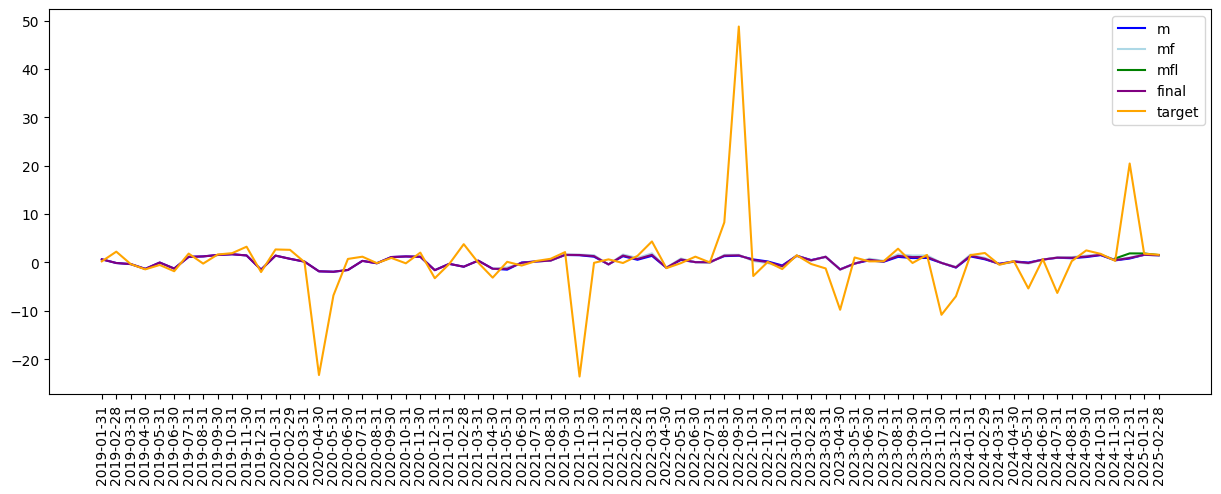

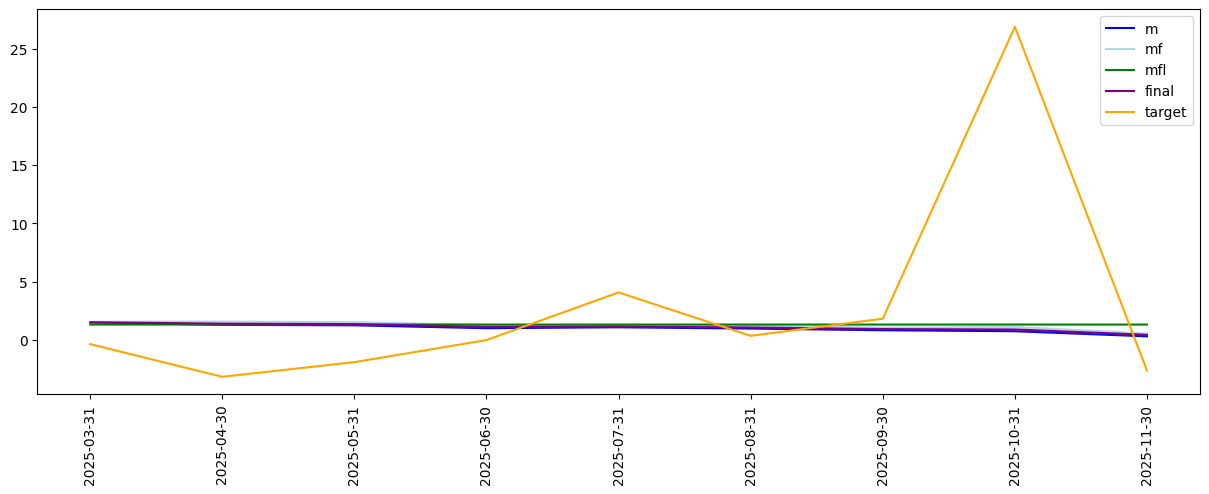

In [21]:
model_start = SVR()
model_middle = SVR()
model_end = SVR()
results, results_test = train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train, target_name)
results

MSE on Train set:  55.35600753792016
MSE on Test set:  81.24458975176013


C:\Users\judit\AppData\Local\Temp\ipykernel_42408\2041393093.py:96: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.62043696 -0.13953312 -0.36541505 -1.35061455 -0.03965223 -1.2837199
  1.13391988  1.2245284   1.52051117  1.67184631  1.42296101 -1.5091492
  1.39038779  0.72862832  0.14502725 -1.85808212 -1.94241026 -1.58171572
  0.30103487 -0.18962003  1.09628191  1.21580009  1.15650083 -1.61697254
 -0.31374769 -0.90540131  0.35392704]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result.loc[mask_f, 'final'] = result.loc[mask_f, 'pred_m']
C:\Users\judit\AppData\Local\Temp\ipykernel_42408\2041393093.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.80700275 1.71051239 1.72290683 1.40904477 1.43180532 1.21415573
 1.09975672 1.0037366  0.46594891]' has dtype incompatible wit

,pred_m,pred_mf,pred_mfl,final,target
index,,,,,
2019-01-31,0.620437,NaN,NaN,0.620437,0.207187
2019-02-28,-0.139533,NaN,NaN,-0.139533,2.208051
2019-03-31,-0.365415,NaN,NaN,-0.365415,-0.367747
2019-04-30,-1.350615,NaN,NaN,-1.350615,-1.450762
2019-05-31,-0.039652,NaN,NaN,-0.039652,-0.543008
...,...,...,...,...,...
2024-10-31,1.491635,0.384184,NaN,1.726656,1.749173
2024-11-30,0.406813,-0.159543,0.169431,0.406333,0.306333
2024-12-31,0.788926,0.274975,0.939485,1.872248,20.434410


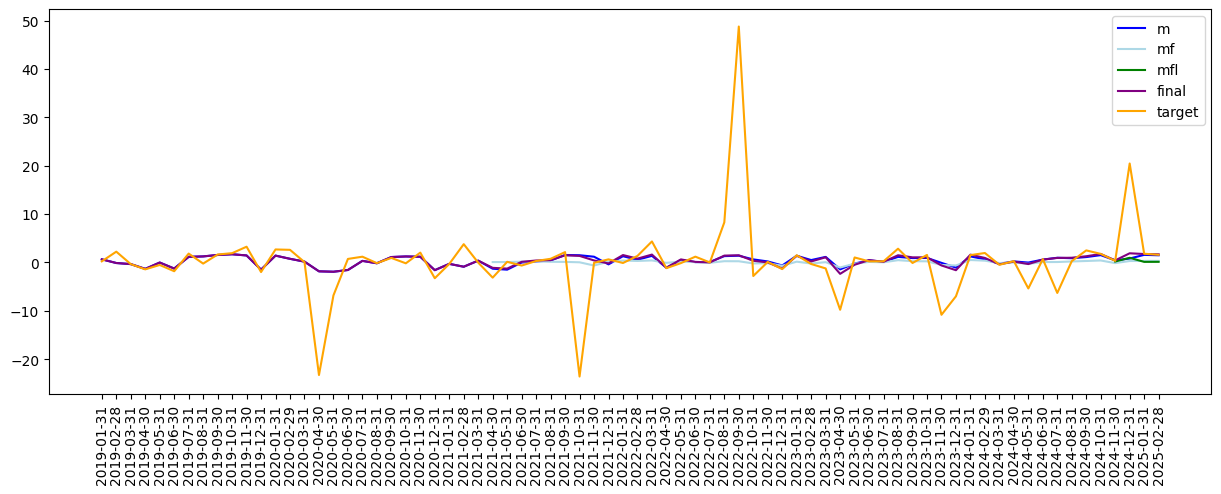

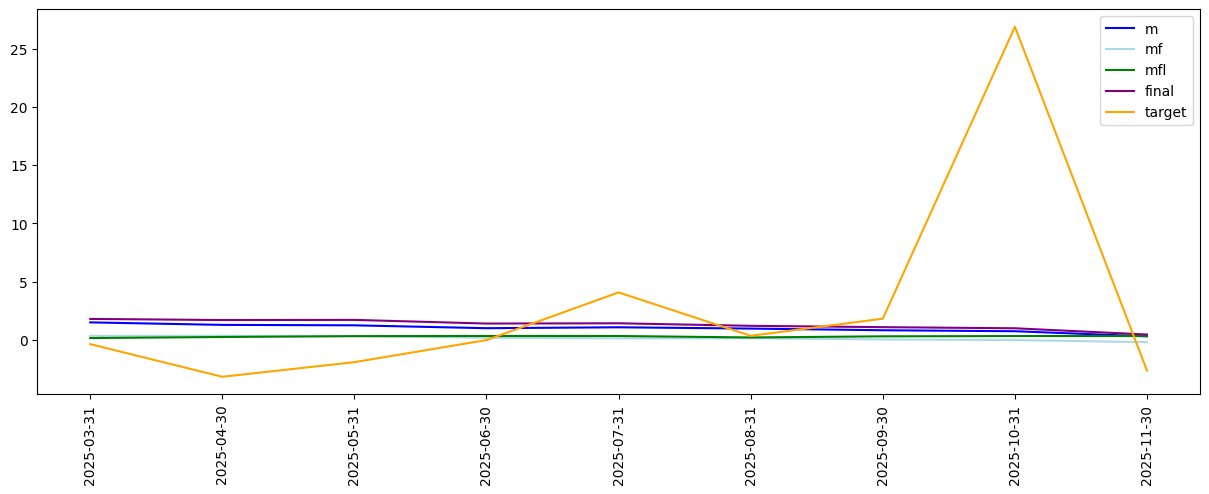

In [22]:
model_start = SVR()
model_middle = SVR()
model_end = SVR()
results, results_test = train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train, target_name, model_simple=1)
results

## Random Forest

MSE on Train set:  16.16440939857517
MSE on Test set:  92.69231890906632


C:\Users\judit\AppData\Local\Temp\ipykernel_42408\2570047379.py:92: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  0.95962508   0.71766638  -0.32703234  -0.87263461   0.02189832
  -0.40325363   0.43612417   0.43612417   0.40079379   0.18135299
   0.43612417  -1.75831949   0.43612417   0.48074316   0.02189832
 -14.41663586 -10.95583545  -0.14848244   0.40079379  -0.36702852
   0.43612417   0.43612417  10.48789957  -1.80257825  -0.14949031
  -0.19115757  -0.4042615 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result.loc[mask_f, 'final'] = result.loc[mask_f, 'pred_m']
C:\Users\judit\AppData\Local\Temp\ipykernel_42408\2570047379.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.04717199 5.43720392 4.18809692 5.70340333 4.04717199 3.75996933
 3.90089426 2.58185968 5.4162006

,pred_m,pred_mf,pred_mfl,final,target
index,,,,,
2019-01-31,0.959625,NaN,NaN,0.959625,0.207187
2019-02-28,0.717666,NaN,NaN,0.717666,2.208051
2019-03-31,-0.327032,NaN,NaN,-0.327032,-0.367747
2019-04-30,-0.872635,NaN,NaN,-0.872635,-1.450762
2019-05-31,0.021898,NaN,NaN,0.021898,-0.543008
...,...,...,...,...,...
2024-10-31,0.640198,1.709351,NaN,1.055489,1.749173
2024-11-30,-1.515470,-1.542971,0.306333,-1.467513,0.306333
2024-12-31,11.240299,13.128140,20.434410,12.244339,20.434410


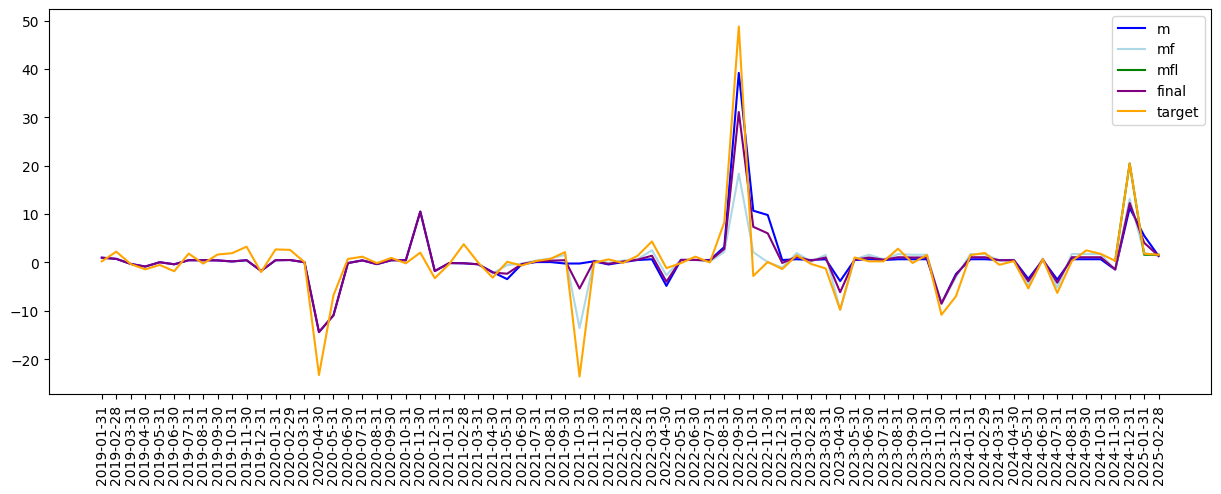

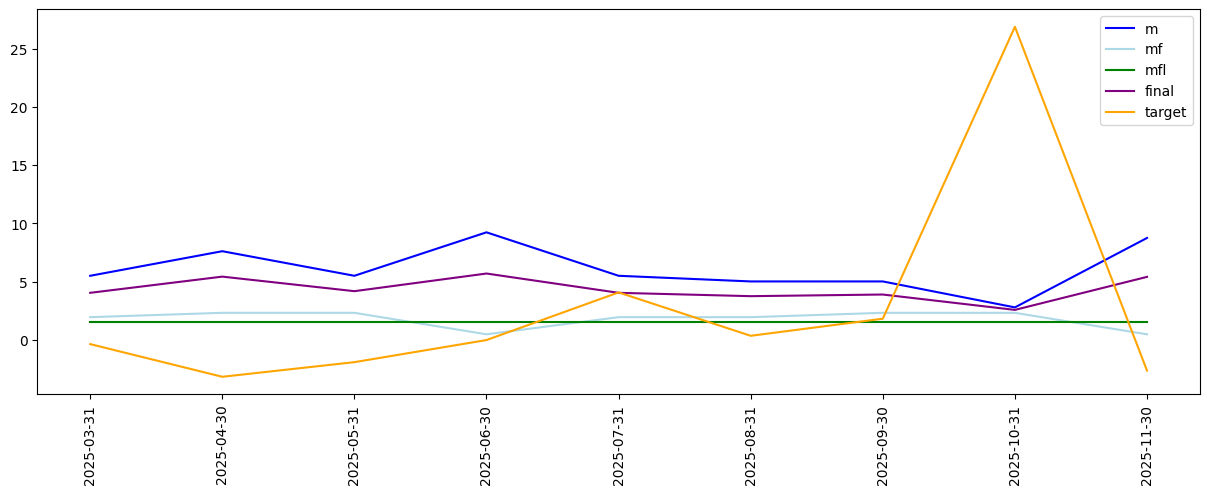

In [24]:
model_start = RandomForestRegressor(n_estimators=5, max_depth=5)
model_middle = RandomForestRegressor(n_estimators=5, max_depth=5)
model_end = RandomForestRegressor(n_estimators=1, max_depth=5)
results, results_test = train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train, target_name)
results

MSE on Train set:  12.189230254769209
MSE on Test set:  105.20559940879073


C:\Users\judit\AppData\Local\Temp\ipykernel_42408\2041393093.py:96: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  1.09869857  10.80858976  10.80858976   9.87516644   0.53661789
  -0.40464228   1.095811     1.095811     0.86577673   1.095811
   1.095811    -1.00079532   1.095811     0.57530755   0.11011245
 -18.82934997   4.30243758  -1.00079532  10.29292992   9.87516644
   1.095811     1.095811     1.095811    -2.47805391   0.57085825
   1.18403136   0.34318121]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result.loc[mask_f, 'final'] = result.loc[mask_f, 'pred_m']
C:\Users\judit\AppData\Local\Temp\ipykernel_42408\2041393093.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.87663731 5.53680878 8.30545101 5.3384386  6.19252929 7.95724515
 7.42524075 4.49947053 8.15889432]

,pred_m,pred_mf,pred_mfl,final,target
index,,,,,
2019-01-31,1.098699,NaN,NaN,1.098699,0.207187
2019-02-28,10.808590,NaN,NaN,10.808590,2.208051
2019-03-31,10.808590,NaN,NaN,10.808590,-0.367747
2019-04-30,9.875166,NaN,NaN,9.875166,-1.450762
2019-05-31,0.536618,NaN,NaN,0.536618,-0.543008
...,...,...,...,...,...
2024-10-31,-1.300500,0.859148,NaN,-0.311302,1.749173
2024-11-30,-2.260852,2.612190,3.910473,3.991580,0.306333
2024-12-31,15.047442,3.680543,3.910473,20.434410,20.434410


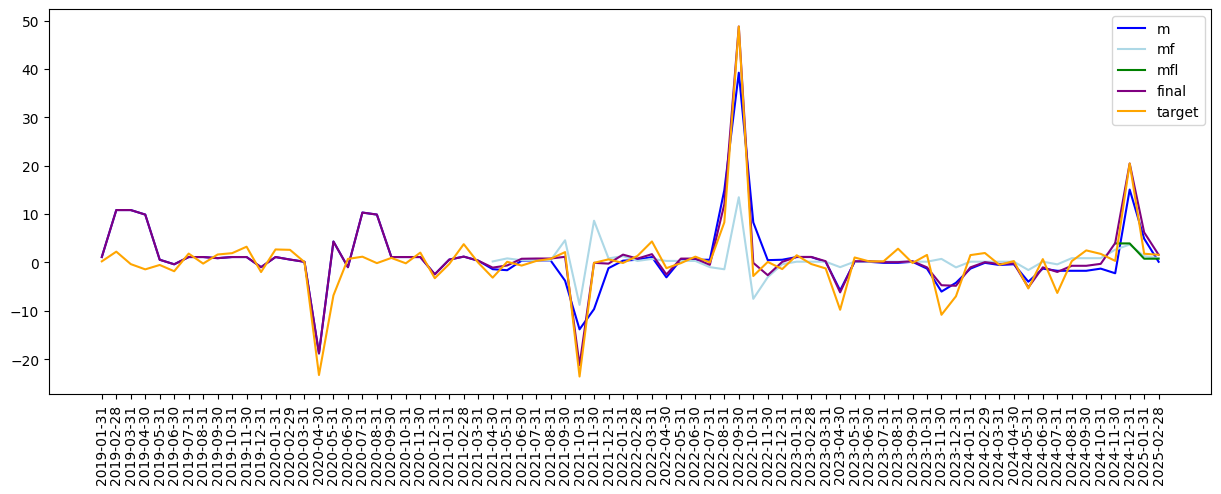

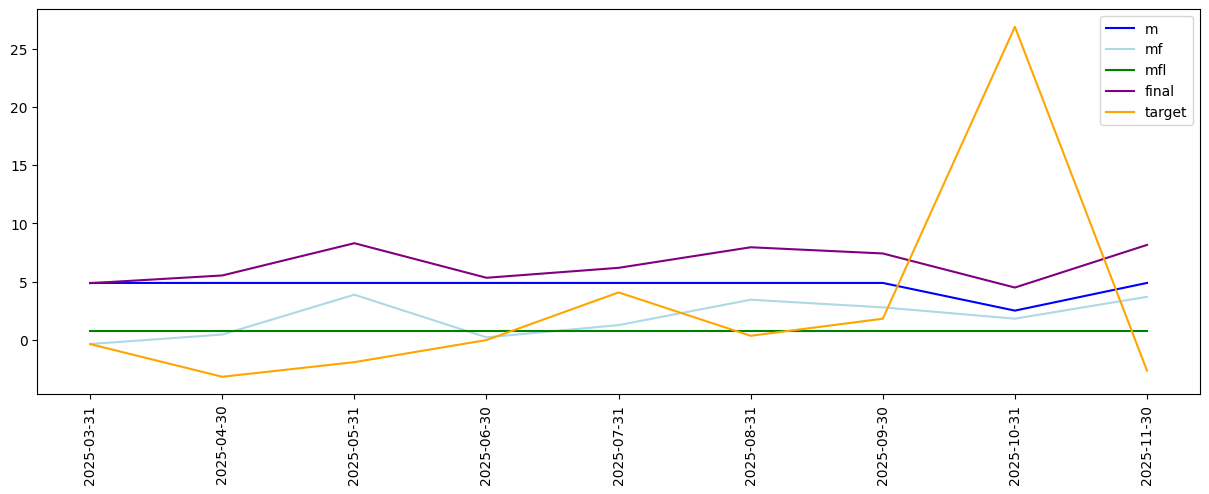

In [25]:
model_start = RandomForestRegressor(n_estimators=5, max_depth=5)
model_middle = RandomForestRegressor(n_estimators=5, max_depth=5)
model_end = RandomForestRegressor(n_estimators=1, max_depth=5)
results, results_test = train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train, target_name, model_simple=1)
results

### ANN

In [82]:
features_train_transf, features_test_transf, target_train, target_test, columns = preprocessing(df, dict_lag,number_train, target_name)

Epoch 1/10


c:\Users\judit\Portfolioprojekte\dpp_projekt_2026\.venv\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 3.3727 - mae: 3.3727 - val_loss: 5.1064 - val_mae: 5.1064
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.3576 - mae: 3.3576 - val_loss: 5.1064 - val_mae: 5.1064
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3.3572 - mae: 3.3572 - val_loss: 5.1064 - val_mae: 5.1064
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.3571 - mae: 3.3571 - val_loss: 5.1064 - val_mae: 5.1064
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.3567 - mae: 3.3567 - val_loss: 5.1064 - val_mae: 5.1064
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.3561 - mae: 3.3561 - val_loss: 5.1064 - val_mae: 5.1064
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 3.3557 - mae: 3.3557 - val_loss: 5.1064 - val_mae: 5.1064
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3.3551 - mae: 3.3551 - val_loss: 5.1064 - val_mae: 5.1064
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 3.3546 - mae: 3.3546 - val_loss: 5

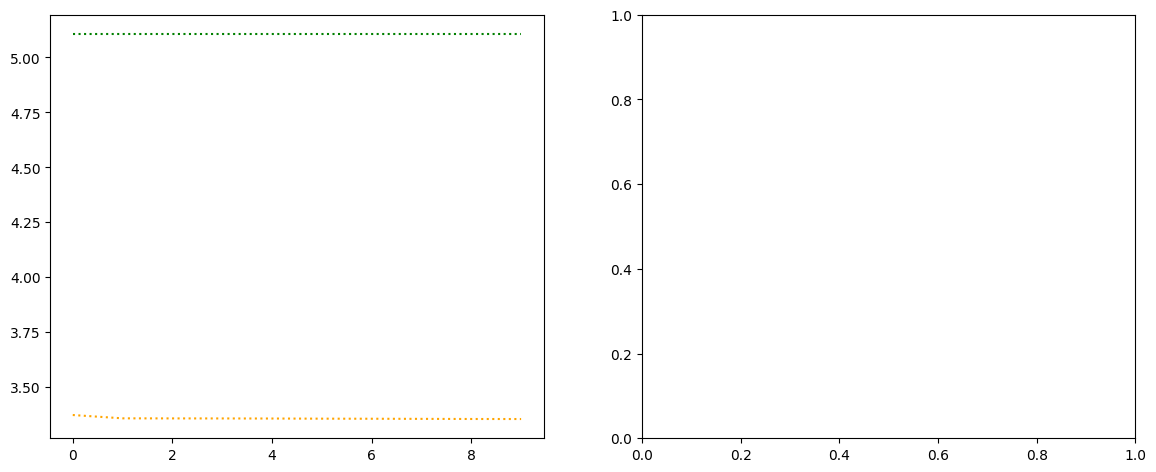

In [99]:
model_an = Sequential()
model_an.add(Dense(1,  input_dim=features_train_transf.shape[1]))#activation='sigmoid',
model_an.add(Dense(10, activation = 'relu'))
#model_an.add(Dropout(rate=0.3))
#model_an.add(Dense(15, activation = 'relu'))
#model_an.add(Dropout(rate=0.3))
model_an.add(Dense(10, activation = 'relu'))
#model_an.add(Dropout(rate=0.3))
model_an.add(Dense(1))#,activation = none))

model_an.compile(loss = tf.keras.losses.mae,
                optimizer = tf.keras.optimizers.SGD(),
                metrics = ["mae"])  # compile the model

#early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 2)
hist = model_an.fit(features_train_transf, 
                    target_train, 
                    validation_data=(features_test_transf, target_test),
                    epochs=10, 
                    batch_size=32,
                    #callbacks=[early_stop]
                   )#fits the model
# batch_size: 32 bis 512, also 32, 64, 128, 256, 512


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5.5))
l = len(hist.history['loss'])
ax[0].plot(range(l), hist.history['loss'],linestyle=':', color = 'orange')
ax[0].plot(range(l), hist.history['val_loss'],linestyle=':', color = 'green')

In [104]:
features_train_transf.iloc[[0,1],:]

,Ferrero,LindtSpruengli,Mondelez,EinfPr_Süßwaren (ohne Dauerbackwaren)_lag_by_1,VPI_Schokoladen_lag_by_1,PCOCOUSDM_lag_by_1,PCOFFROBUSDM_lag_by_1,Geleistete Arbeitsstunden_WZ08-1082,Bruttolohn- und -gehaltssumme_WZ08-1082,"ErzPr_Schokolade u.a. kakaoh. Leb.m.zuber.,in Verp.<=2kg"
date,,,,,,,,,,
2019-02-28,NaN,NaN,-1.877512,-0.557064,-0.900532,-0.577297,-0.89877,-0.180332,-1.022140,-0.885974
2019-03-31,NaN,NaN,-1.756921,-0.557064,-0.900532,-0.577297,-0.89877,-0.407618,-1.017112,-0.900447


In [105]:
model_an.predict(features_train_transf.iloc[[0,1],:])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


array([[0.029875],
       [0.029875]], dtype=float32)